In [1]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('NSE-TATAGLOBAL11.csv')

#print the head
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,10/8/2018,208.00,222.25,206.85,216.00,215.15,4642146,10062.83
1,10/5/2018,217.00,218.60,205.90,210.25,209.20,3519515,7407.06
2,10/4/2018,223.50,227.80,216.15,217.25,218.20,1728786,3815.79
3,10/3/2018,230.00,237.50,225.75,226.45,227.60,1708590,3960.27
4,10/1/2018,234.55,234.60,221.05,230.30,230.90,1534749,3486.05


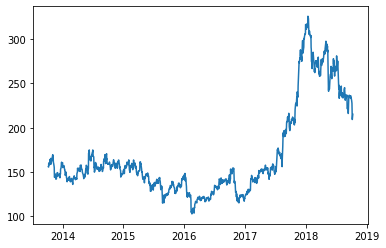

In [2]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%m/%d/%Y')
df.index = df['Date']

#plot
#plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In [3]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


In [4]:
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

In [5]:
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

In [6]:
#creating train and test sets
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

In [7]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [8]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [9]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [10]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

W0831 11:51:05.902081  2660 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0831 11:51:05.922081  2660 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0831 11:51:05.926084  2660 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [11]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

W0831 11:51:06.398318  2660 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0831 11:51:06.658193  2660 deprecation.py:323] From C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0831 11:51:07.967728  2660 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0831 11:51:08.102213  2660 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use t

Epoch 1/1
 - 61s - loss: 0.0010


In [12]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)


In [13]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)


In [14]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [15]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms


10.205379434578548

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


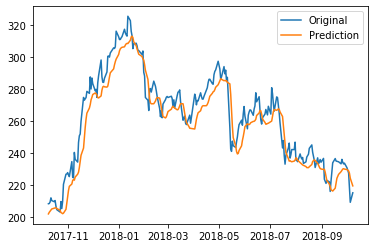

In [16]:
#for plotting

train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
#plt.figure(figsize=(16,8))
plt.plot(valid['Close'], label='Original')
plt.plot(valid['Predictions'], label='Prediction')
plt.legend(loc='best')